<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<span>
<h2>Eliminación de ruido en imagenes de resonancia magnetica, mediante red neuronal convolucional CNN </h2> 
</span>

<p>
MobileNet: Aruitectura mas pequeña y rapida que la arquitectura VGG16 y otros modelos populares, este modelo es de baja potencia y baja latencia y se usa  para la clasificacion, deteccion y otras aplicaciones que resuelven las redes CNN. Este modelo es una buena opcion para dispositivos mobiles debido a su tamaño reducido, a continuacion se muestran algunas comparaciones entre modelos:

- Model     | Size   | Parameters

- VGG16     | 552 MB | 138.000.000
- MobileNet | 17  MB | 4.200.000

Sin embargo la exactitud del modelo MobileNet no es tan exacto como algunos de los grandes modelos. <a href="https://deeplizard.com/learn/video/OO4HD-1wRN8">Ver mas</a> 
</p>



## Instalar librerías

In [36]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [ ]:
pip install tf-nightly

In [ ]:
pip install h5py

In [ ]:
pip install scikit-learn

In [ ]:
!pip uninstall tensorflow-directml

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

In [37]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

## Importar librerías

In [38]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
 
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
import time
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import EarlyStopping

## Configurar GPU con TensorFlow

NOTA: MobileNet es un modelo que no requiere GPU, en nuestro caso la usaremos para dar mas agilidad y mejor rendimiento al modelo ya que disponemos de 3 GPU.

In [ ]:
tensorflow.test.is_gpu_available()
print("Num GPUs available", len(tensorflow.config.experimental.list_physical_devices('GPU')))

print(tensorflow.test.gpu_device_name())
print(tensorflow.test.is_gpu_available())

## Preparacion de imagenes

### Definir conjuntos de datos

#### Definir variables de entrenamiento, validacion y prueba

In [39]:
import os
# os.chdir('C:\\Users\\Juan David\\Documents\\TFM\\ULTIMO_BCK\\ADNI - IDA\\ADNI1_Complete 1Yr 1.5T\\ADNI-PRE-PROCESAMIENTO\\')
# print(os.getcwd())

# Entrenamiento
path_train = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/ENTRENAMIENTO/' 

# Validacion
path_val = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/VALIDACION/' 

# Pruebas
path_test = r'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/PRUEBA/'

### Definir conjuntos de datos en formato KERAS

In [40]:
# Generacion de lotes de datos para modelo en Keras en formato MobileNet

# Entrenamiento
train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=path_train,
                         target_size=(224,224),
                         classes=['AD','CN','MCI'],
                         batch_size=10)

# Validacion
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=path_val,
                         target_size=(224,224),
                         classes=['AD','CN','MCI'],
                         batch_size=10)

# Pruebas
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=path_test,
                         target_size=(224,224),
                         classes=['AD','CN','MCI'],
                         batch_size=10, 
                         shuffle=False)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [41]:
assert train_batches.n == 5343 
assert valid_batches.n == 1265  
assert test_batches.n == 63
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3 

In [42]:
imgs, labels = next(train_batches)

In [43]:
"""Esta funcion mostrara imagenes en un grid con 1 fila y 10 columnas

Parameters
----------
list : numpy.ndarray
"""

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =  axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='Reds')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [44]:
imgs[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

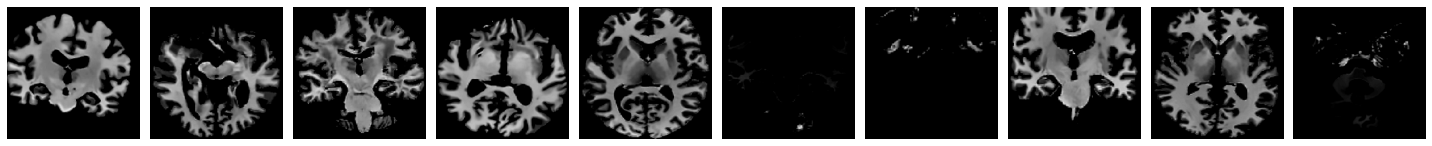

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [45]:
plotImages(imgs)
print(labels)

## Construccion y entrenamiento del modelo CNN - MobileNet afinado

In [46]:
IMG_SHAPE = (224, 224, 3)
base_model = tensorflow.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, 
                                                               include_top=False,
                                                               weights='imagenet',
                                                               pooling='avg')
base_model.trainable = False

inputs = tensorflow.keras.layers.Input(IMG_SHAPE)
x = base_model(inputs)
x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
prediction  = tensorflow.keras.layers.Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 3,294,659
Trainable params: 65,795
Non-trainable params: 3,228,864
_________________________________________________________________


 ## Entrenamiento del modelo afinado MobileNet

In [47]:
with tensorflow.device('DML'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()   

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 3,294,659
Trainable params: 65,795
Non-trainable params: 3,228,864
_________________________________________________________________


In [48]:
with tensorflow.device('DML'):
    
    from keras.callbacks import EarlyStopping
    
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=5, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit(x=train_batches,
                  validation_data=valid_batches,
                  epochs=10,
                  verbose=2,
                  callbacks = [earlystopper])

Epoch 1/10
535/535 [==============================] - 121s 226ms/step - loss: 1.0965 - acc: 0.4191 - val_loss: 1.1388 - val_acc: 0.3660
Epoch 2/10
535/535 [==============================] - 33s 62ms/step - loss: 1.0006 - acc: 0.4887 - val_loss: 1.1528 - val_acc: 0.3755
Epoch 3/10
535/535 [==============================] - 33s 62ms/step - loss: 0.9710 - acc: 0.5138 - val_loss: 1.1128 - val_acc: 0.3945
Epoch 4/10
535/535 [==============================] - 33s 61ms/step - loss: 0.9365 - acc: 0.5467 - val_loss: 1.1038 - val_acc: 0.4071
Epoch 5/10
535/535 [==============================] - 33s 62ms/step - loss: 0.9226 - acc: 0.5465 - val_loss: 1.1115 - val_acc: 0.3905
Epoch 6/10
535/535 [==============================] - 33s 62ms/step - loss: 0.9040 - acc: 0.5632 - val_loss: 1.1323 - val_acc: 0.4024
Epoch 7/10
535/535 [==============================] - 33s 61ms/step - loss: 0.8865 - acc: 0.5746 - val_loss: 1.1721 - val_acc: 0.3905
Epoch 8/10
535/535 [==============================] - 33s 61

 ## Prediccion con conjunto de pruebas

In [60]:
test_labels = test_batches.classes

In [61]:
predictions = model.predict(x = test_batches, verbose = 0)

In [62]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

In [63]:
test_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

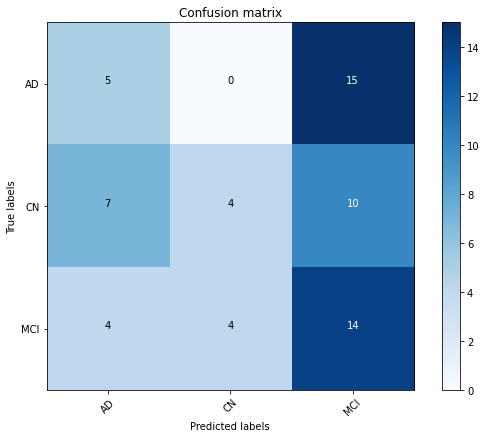

In [64]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento

In [65]:
print(model.history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [66]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.61370015, 0.6264271, 0.62904733, 0.64514315, 0.6498222, 0.65899307, 0.65992886, 0.6689126, 0.66947407, 0.6790193, 0.6842598, 0.7007299, 0.69623804, 0.69661236, 0.70877784, 0.7181359, 0.7200075, 0.7200075, 0.7237507, 0.73198575, 0.7361033, 0.74059516]
[0.3770751, 0.38577074, 0.38102767, 0.37628457, 0.3960474, 0.3770751, 0.3715415, 0.38577074, 0.3604743, 0.37470356, 0.36284584, 0.37470356, 0.37470356, 0.37470356, 0.36996046, 0.3667984, 0.36205533, 0.36442688, 0.37628457, 0.35968378, 0.36758894, 0.36916995]
[0.8184032884515138, 0.8079955010250804, 0.7909630901822878, 0.7787123027196788, 0.7625760842235307, 0.7580300210880113, 0.7537049218529779, 0.7418284510687096, 0.7362214875270338, 0.720344622896424, 0.7093075857656894, 0.6932970877446063, 0.6882084283671663, 0.6775993295383436, 0.6701632820888336, 0.6579420546311331, 0.6483907682739928, 0.6420854073148218, 0.6434699865833731, 0.6301203383536859, 0.6166744623517981, 0.6112670269649215]
[1.194788125086957, 1.1795177741313543, 1.19200

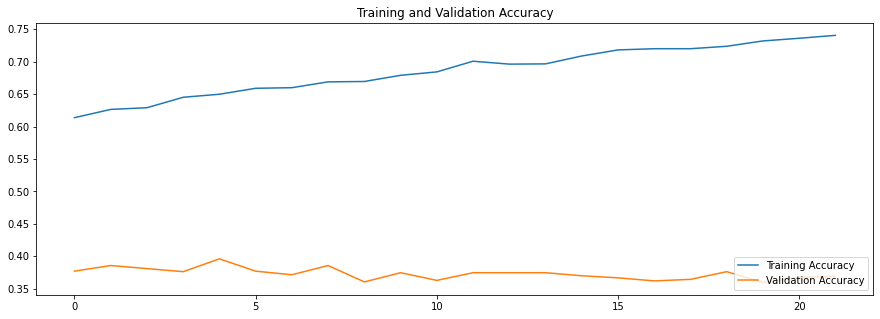

In [68]:
epochs_ft = 22
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(epochs_ft)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

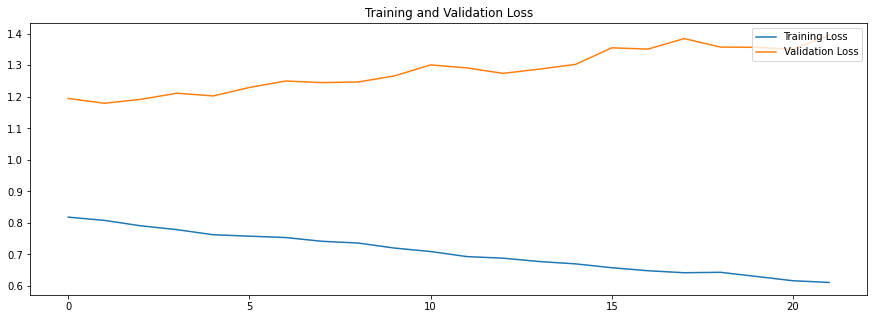

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [ ]:
https://github.com/tensorflow/tensorflow/issues/35515

<!-- GoogLeNet 
ILSVRC-2013 (Clarifai)
MSRA
Zeler & Fergus
OverFeat
Krizhevsky -->

In [ ]:
# TODO: Grafico de Epochs: https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

In [ ]:
https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

https://towardsdatascience.com/alzheimer-diagnosis-with-deep-learning-a-survey-265406fa542a

https://www.youtube.com/watch?v=3V9YFPfgyAY

In [ ]:
https://github.com/Yale-Deep-Learning-for-Alzheimers/Alzheimers-DL-Network

In [ ]:
https://www.kaggle.com/code/muneebkhurram/alzheimer-mri-classification

0. Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API
https://www.youtube.com/watch?v=_L2uYfVV48I&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

0.1 Data Augmentation with TensorFlow's Keras API
https://www.youtube.com/watch?v=WSvpLUietIM&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14

1.Keras with TensorFlow - Data Processing for Neural Network Training
https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3

2.Build and Train a Convolutional Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=3V9YFPfgyAY&t=326s

3.Keras with TensorFlow Prerequisites - Getting Started With Neural Networks
https://www.youtube.com/watch?v=e47ISlpYFok

4.Train a Fine-Tuned Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=TguZ0WK0orQ

5.Create a Confusion Matrix for Neural Network Predictions
https://www.youtube.com/watch?v=VYGVOwlT4oE&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=9

6.MobileNet Image Classification with TensorFlow's Keras API
https://www.youtube.com/watch?v=5JAZiue-fzY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=19

7.Save and Load a Model with TensorFlow's Keras API
https://www.youtube.com/watch?v=8Nl-of5C3uA&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

https://keras.io/api/applications/

https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/